In [1]:
from becquerel import Spectrum
import numpy as np
import matplotlib.pyplot as plt
import becquerel as bq
import scipy.integrate as integrate
import math as m
import importlib
import os

In [198]:
import analysis_methods as am
import PF
import ROI
importlib.reload(am)
importlib.reload(PF)
importlib.reload(ROI)

<module 'ROI' from 'C:\\Users\\ahanks\\DoseNet\\radwatch-analysis\\ROI.py'>

In [4]:
def plot_spec(spectrum, xmode='channel'):
    if xmode == 'channel':
        facecolor = 'green'
    else:
        facecolor = 'blue'
    plt.figure()
    spectrum.fill_between(xmode=xmode, facecolor=facecolor, alpha=0.4, ax=plt.gca())
    spectrum.plot('k-', lw=0.7, xmode=xmode, ax=plt.gca())
    if xmode == 'channel':
        plt.xlim(0, spectrum.bin_edges_raw.max())
        plt.title('Uncalibrated spectrum')
    else:
        plt.xlim(0, spectrum.energies_kev[-1])
        plt.title('Calibrated spectrum')
    plt.yscale('log')
    plt.ylim(2e-1)
    plt.tight_layout()
def plot_calibrator(cal):
    cal.peakfinder.spectrum.apply_calibration(cal.cal)
    print('fit gain:', cal.gain, 'keV/channel')
    print('fit channels:', cal.fit_channels)

    plt.figure()
    plt.title('Peaks used in fit')
    cal.plot()
    plt.tight_layout()
    #plt.savefig('peaks used in fit.png',dpi = 200)

    plot_spec(cal.peakfinder.spectrum, xmode='channel')
    for x, erg in zip(cal.fit_channels, cal.fit_energies):
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-10:chan+10].max() * 1.5
        plt.plot([x, x], [1e-1, y], 'r-', alpha=0.5)
        plt.text(x, y, '{:.1f} keV'.format(erg))
    #plt.savefig('Uncal spec.png',dpi = 200)


    plot_spec(cal.peakfinder.spectrum, xmode='energy')
    for erg in cal.fit_energies:
        x = int(erg / cal.gain)
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-15:chan+15].max() * 1.5
        plt.plot([erg, erg], [1e-1, y], 'r-', alpha=0.5)
        plt.text(erg, y, '{:.1f} keV'.format(erg))
    #plt.savefig('cal spec.png',dpi=200)
        
        


In [128]:
file_path = r'C:\Users\ahanks\Google Drive\RadWatch\Gamma\Gamma Spectra\Fish Samples 2019'
spec = file_path + r'\efficiency_calibration_2020-3-5.Spe'
bg = file_path + r'\Background_Spectrum_12_20_19.Spe'
spec = bq.Spectrum.from_file(spec)
bg = bq.Spectrum.from_file(bg)

SpeFile: Reading file C:\Users\ahanks\Google Drive\RadWatch\Gamma\Gamma Spectra\Fish Samples 2019\efficiency_calibration_2020-3-5.Spe
SpeFile: Reading file C:\Users\ahanks\Google Drive\RadWatch\Gamma\Gamma Spectra\Fish Samples 2019\Background_Spectrum_12_20_19.Spe


c:\users\ahanks\becquerel\becquerel\parsers\spectrum_file.py:136: SpectrumFileParsingWarning:

Spectrum will be initated without an energy calibration;invalid calibration, energies not monotonically increasing.



In [130]:
# apply the kernel to the data to get SNR
kernel = bq.GaussianPeakFilter(3700, 10, 5)
finder = bq.PeakFinder(spec, kernel)
cal = bq.AutoCalibrator(finder)

[506.5, 793.5, 914.5, 1345.5, 2111.5, 3881.5, 3950.5, 7107.5]


c:\users\ahanks\becquerel\becquerel\core\peakfinder.py:181: DeprecationWarning:

channels is deprecated and will be removed in a future release. Use centroids instead.



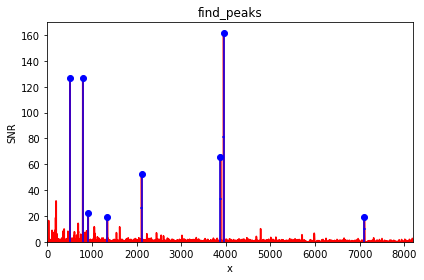

In [131]:
cal.peakfinder.find_peaks(min_snr=15, xmin=400)
print(cal.peakfinder.channels)
plt.figure()
plt.title('find_peaks')
cal.peakfinder.plot()
plt.tight_layout()
#plt.savefig('find_peaks_spec',dpi = 200)

C:\Users\ahanks\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



found best gain: 0.369757 keV/channel
fit gain: 0.369756699383546 keV/channel
fit channels: [ 914.5 3881.5 3950.5 7107.5]


c:\users\ahanks\becquerel\becquerel\core\spectrum.py:440: DeprecationWarning:

energies_kev is deprecated and will be removed in a future release. Use bin_centers_kev instead.



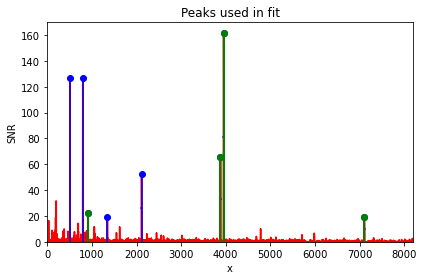

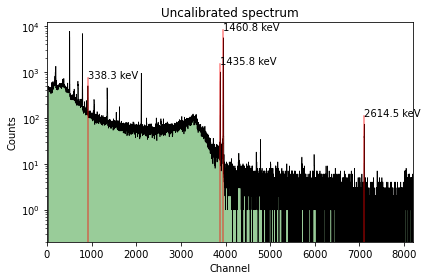

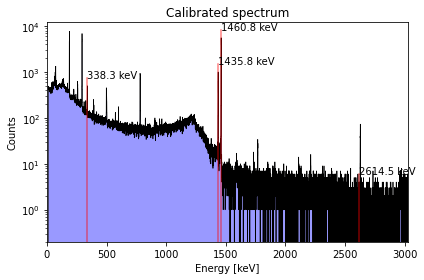

In [132]:
# perform calibration
cal.fit(
    [1435.795, 1460.82,2614.51],
    optional=[201.83,306.78, 351.93, 338.32,569.33,604.721,788.742,795.864, 911.20, 1120.294, 1620.50, 1764.49, 2118.514],
    gain_range=[0.3, 10],
    de_max=100.,
)
plot_calibrator(cal)
spectrum = cal.peakfinder.spectrum


C:\Users\ahanks\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

c:\users\ahanks\becquerel\becquerel\core\peakfinder.py:181: DeprecationWarning:

channels is deprecated and will be removed in a future release. Use centroids instead.



[246.5, 539.5, 706.5, 1564.5, 1792.5, 1874.5, 2827.5, 4560.5, 5518.5]


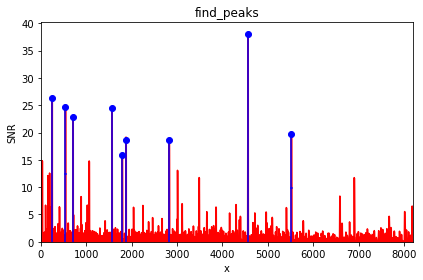

In [133]:
kernel = bq.GaussianPeakFilter(3700, 10, 5)
finder = bq.PeakFinder(bg, kernel)
cal = bq.AutoCalibrator(finder)
cal.peakfinder.find_peaks(min_snr=15, xmin=200)
print(cal.peakfinder.channels)
plt.figure()
plt.title('find_peaks')
cal.peakfinder.plot()
plt.tight_layout()
#plt.savefig('find peaks bg.png',dpi=200)

C:\Users\ahanks\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



found best gain: 0.320388 keV/channel
fit gain: 0.3203875656420919 keV/channel
fit channels: [2827.5 4560.5 5518.5]


c:\users\ahanks\becquerel\becquerel\core\spectrum.py:440: DeprecationWarning:

energies_kev is deprecated and will be removed in a future release. Use bin_centers_kev instead.



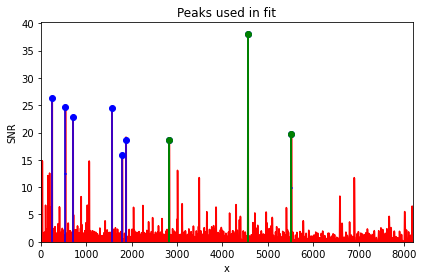

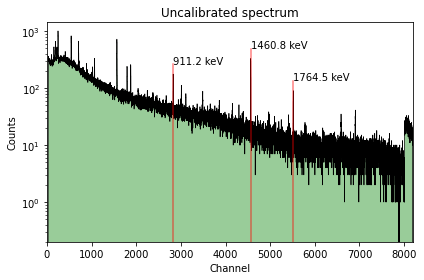

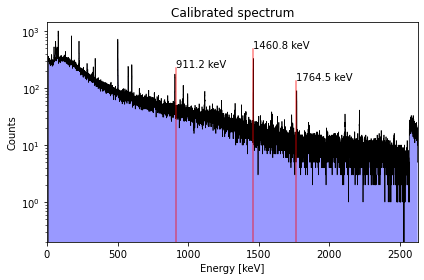

In [134]:
# perform calibration
cal.fit(
    [1460.82, 1764.49],
    optional=[186.21,238.63,609.32,911.20,242.00,295.22,338.32,351.93,1620.50],
    gain_range=[2.5e-2, 10],
    de_max=100.,
)
plot_calibrator(cal)
background = cal.peakfinder.spectrum

In [135]:
#Find Lu-176, La-138, K-40
source_isotopes = np.array(['Lu_176_1','Lu_176_2','Lu_176_3',
                            'La_138_1','La_138_2',
                           'K-40']); #get counts under the peak subtrack the background
source_energies = np.array([75,186,294,
                           782,1435.795,
                           1460]);
source_activities = np.array([16.259,16.259,16.259,
                             11.646,11.646,
                              424.65]);#Bq/L
branching_ratio = np.array([0.11,0.86,0.94,
                           0.34,0.66,
                           0.11]);
activities_uncer = np.array([1.6259,1.6259,1.6259,
                            0.02329,0.02329,
                            0.8493])
'''The real source energies:
Lu-176: 88.34, 201.83, 306.78
La-138: 788.742,1435.795
K-40: 1460.83'''

C:\Users\ahanks\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



'The real source energies:\nLu-176: 88.34, 201.83, 306.78\nLa-138: 788.742,1435.795\nK-40: 1460.83'

In [182]:
#roi = ROI.ROI(spectrum, background, source_energies, sub_type = 0)
#delta_e = 8
#window = np.array([[-2, -1], [-0.5, 0.5], [1, 2]])
#roi.set_sideband(delta_e,window)
#roi.find_peak_energies()
#target_peaks = roi.target_peaks
#roi_result,roi_uncer = roi.get_counts()

roi = ROI.ROI(spectrum, background, source_energies, 0)

roi.set_sideband(source_energies.tolist()[0], 8, [[-2, -1.1], [-0.4, 0.4], [1, 2]])
roi.set_sideband(source_energies.tolist()[1], 8, [[-2, -1], [-0.5, 0.5], [1, 2]])
roi.set_sideband(source_energies.tolist()[2], 8, [[-2, -1], [-0.5, 0.5], [1, 2]])
roi.set_sideband(source_energies.tolist()[3], 8, [[-2, -1], [-0.5, 0.5], [1, 2]])
roi.set_sideband(source_energies.tolist()[4], 8, [[-2, -1], [-0.6, 0.6], [1, 2]])
roi.set_sideband(source_energies.tolist()[5], 8, [[-2, -1], [-0.6, 0.6], [1, 2]])

roi.find_peak_energies()

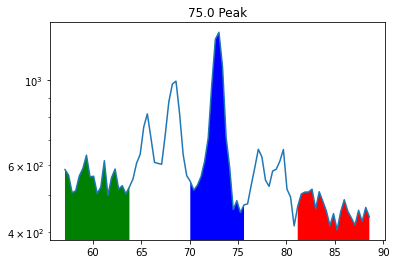

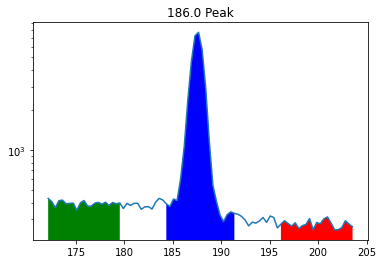

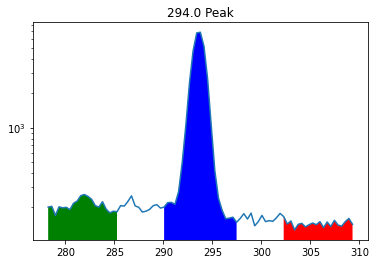

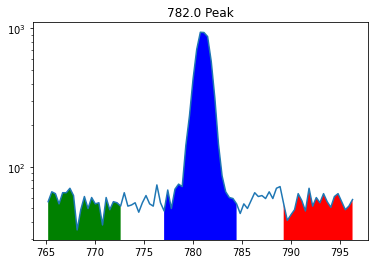

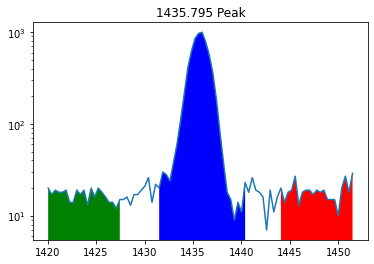

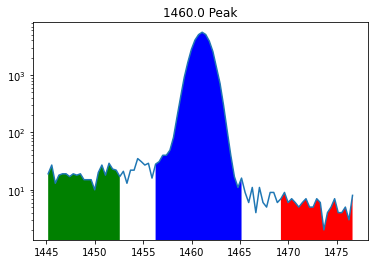

In [183]:
for i in range(len(source_energies.tolist())):
    roi.plot_peak_region(spectrum, source_energies, source_energies.tolist()[i])

In [184]:
print(roi.roi_pars[f'75.0'])
fg_bins = roi.get_roi_windows(roi.roi_pars[f'75.0'],0)
bg_bins = roi.get_roi_windows(roi.roi_pars[f'75.0'],1)
print(fg_bins)
print(bg_bins)
print()
print(fg_bins[0][0][-1]-fg_bins[0][0][0])
print(fg_bins[1][0][-1]-fg_bins[1][0][0])
print(fg_bins[2][0][-1]-fg_bins[2][0][0])

np.sum(spectrum.counts_vals[fg_bins[0][0][0]:fg_bins[0][0][-1]])/(fg_bins[0][0][-1]-fg_bins[0][0][0])

[73, 8, [[-2, -1.1], [-0.4, 0.4], [1, 2]], [[-2, -1], [-0.5, 0.5], [1, 2]]]
[(array([154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173], dtype=int64),), (array([189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
       202, 203, 204, 205], dtype=int64),), (array([219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240], dtype=int64),)]
[(array([178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202],
      dtype=int64),), (array([215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227,
       228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239],
      dtype=int64),), (array([253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265,
       266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277],
      dtype=int64),)]

19
16
21


C:\Users\ahanks\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



549.8421052631579

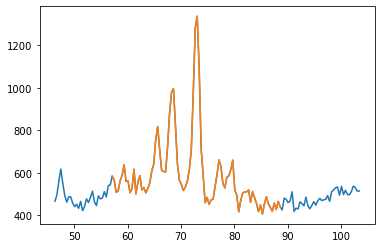

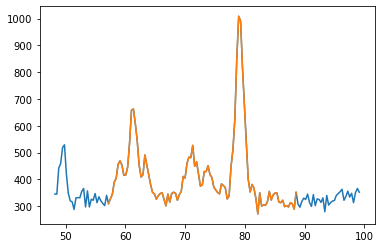

In [185]:
plt.plot(spectrum.bin_centers_kev[125:280],spectrum.counts_vals[125:280])
plt.plot(spectrum.bin_centers_kev[154:240],spectrum.counts_vals[154:240])
plt.show()

plt.plot(background.bin_centers_kev[150:310],background.counts_vals[150:310])
plt.plot(background.bin_centers_kev[178:277],background.counts_vals[178:277])
plt.show()

C:\Users\ahanks\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



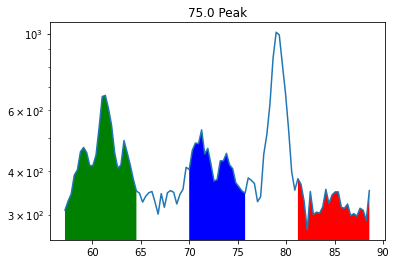

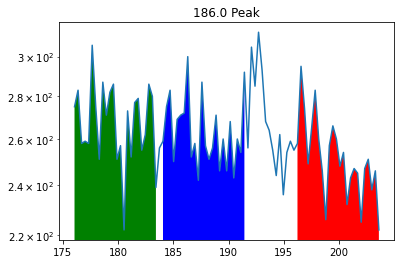

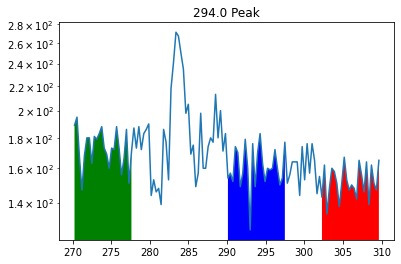

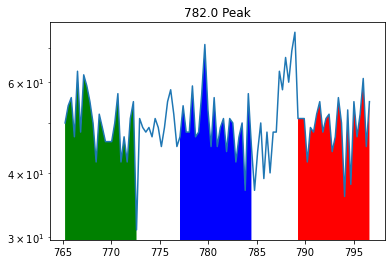

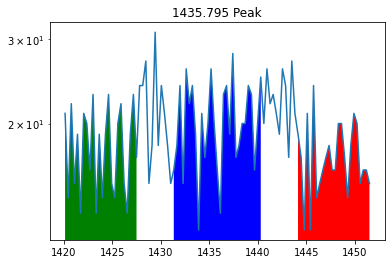

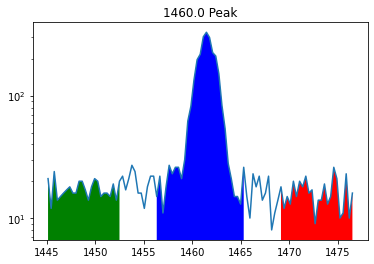

In [186]:
roi.set_sideband(source_energies.tolist()[0], 8, [[-2, -1], [-0.4, 0.4], [1, 2]], 1)
roi.set_sideband(source_energies.tolist()[1], 8, [[-1.5, -0.5], [-0.5, 0.5], [1, 2]], 1)
roi.set_sideband(source_energies.tolist()[2], 8, [[-3, -2], [-0.5, 0.5], [1, 2]], 1)
roi.set_sideband(source_energies.tolist()[3], 8, [[-2, -1], [-0.5, 0.5], [1, 2]], 1)
roi.set_sideband(source_energies.tolist()[4], 8, [[-2, -1], [-0.6, 0.6], [1, 2]], 1)
roi.set_sideband(source_energies.tolist()[5], 8, [[-2, -1], [-0.6, 0.6], [1, 2]], 1)

for i in range(len(source_energies.tolist())):
    roi.plot_peak_region(background, source_energies, source_energies.tolist()[i], 1)

In [187]:
target_peaks = roi.target_peaks
roi_result,roi_uncer = roi.get_counts()

#peakfit = PF.PF(spectrum,background,source_energies)
#pf_result = peakfit.get_counts()
print(target_peaks)
print('ROI result:',roi_result)
print('uncertainties:',roi_uncer)
#print('Lu_176 PF result:',pf_result)

C:\Users\ahanks\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



background spec sidebands 2700.556523285468
bg peak counts 2330.268481059213
signal bg 10087.5
signal peak 11317.0
background spec sidebands 1813.0291922127153
bg peak counts 1839.6550121448981
signal bg 7042.0
signal peak 37622.00000000001
background spec sidebands 1135.4529986379935
bg peak counts 1124.1042885029647
signal bg 3513.5
signal peak 33912.0
background spec sidebands 347.59062195619754
bg peak counts 349.4820736453689
signal bg 1141.0000000000002
signal peak 6009.999999999999
background spec sidebands 122.07138209344902
bg peak counts 170.52164459299436
signal bg 370.5
signal peak 6476.000000000001
background spec sidebands 116.54252330971714
bg peak counts 781.8970290467167
signal bg 258.5
signal peak 35053.0
[  75.     186.     294.     782.    1435.795 1460.   ]
ROI result: [1599.7880422262547, 30553.374180067825, 30409.84871013503, 4867.108548310827, 6057.049737500455, 34129.145494263]
uncertainties: [140.12727465956286, 209.62517081849498, 193.4162125569682, 84.319290

In [199]:
eff,eff_uncer = am.efficiency(roi_result,source_activities,branching_ratio,roi_uncer,activities_uncer,spectrum.livetime)
print(eff,eff_uncer)

[0.012423484819179048, 0.03034830220454708, 0.027635038784606793, 0.017071938317031438, 0.010944802324977939, 0.010147734704356353] [0.0016515391015027425, 0.0030419647069630474, 0.002769087921520977, 0.0002977235331933983, 0.0001520714244794491, 5.954052736892109e-05]


In [200]:
plot_eff = am.Efficiency(source_energies,eff,eff_uncer)

plot_eff.fitting()
plot_eff.plotter_pretty(0.04,save=True)

In [191]:
plot_eff.save_fit()

Saving efficiency curve to  eff_calibration_parameters.json
Saving fit parameters:  [-0.09752124 -0.41681079 -0.73212546 -1.11108914 -4.56337189]
Saving fit covariance:  [[3.26231638e-03 1.83712674e-02 3.06572343e-02 1.44862197e-02
  2.61692463e-04]
 [1.83712674e-02 1.04165237e-01 1.75854651e-01 8.50282275e-02
  1.72872980e-03]
 [3.06572343e-02 1.75854651e-01 3.02968626e-01 1.52669208e-01
  3.83852009e-03]
 [1.44862197e-02 8.50282275e-02 1.52669208e-01 8.38702927e-02
  3.30108144e-03]
 [2.61692463e-04 1.72872980e-03 3.83852009e-03 3.30108144e-03
  8.76676582e-04]]


In [192]:
test_eff = am.Efficiency()
test_eff.set_parameters()

Loaded fit parameters 0-4: [-0.09752124 -0.41681079 -0.73212546 -1.11108914 -4.56337189]
Loaded fit covariance: [[3.26231638e-03 1.83712674e-02 3.06572343e-02 1.44862197e-02
  2.61692463e-04]
 [1.83712674e-02 1.04165237e-01 1.75854651e-01 8.50282275e-02
  1.72872980e-03]
 [3.06572343e-02 1.75854651e-01 3.02968626e-01 1.52669208e-01
  3.83852009e-03]
 [1.44862197e-02 8.50282275e-02 1.52669208e-01 8.38702927e-02
  3.30108144e-03]
 [2.61692463e-04 1.72872980e-03 3.83852009e-03 3.30108144e-03
  8.76676582e-04]]


In [193]:
test_eff.get_eff(1000)

0.014600978008315505

In [124]:
test_eff.get_eff_error(1000)

0.0005506337510019412

In [194]:
test_eff.get_eff_error(2000)/plot_eff.get_eff(2000)

0.16845762443687085

In [195]:
test_eff.plotter_pretty()